# Interference (H=A+B, H=A+B+C)

In [2]:
## import necessary packages
import numpy as np
from scipy.linalg import expm

# from trotter import *
# from bounds import *
# from lattice_hamiltonians import interference_bound, tight_bound
# from lattice_hamiltonians import *
from quantum_simulation_recipe.trotter import *
from quantum_simulation_recipe.bounds import tight_bound, interference_bound, norm, commutator
from quantum_simulation_recipe.spin import Nearest_Neighbour_1d, Power_Law
from quantum_simulation_recipe.plot_config import *
cc, lcc = default_color_cycle, [lighten_color(color, 0.3) for color in default_color_cycle]

fig_dir, data_dir = './figs', './data'

## Heisenberg (PF1, XYZ)

In [5]:
n = 4
J, h = 1, 0.2 
hnn = Nearest_Neighbour_1d(n=n, Jx=J, Jy=J, Jz=J, hx=h, hy=0, hz=0, pbc=True)
hnn.ham_par
hnn.ham_xyz
# tight_bound(hnn.ham_xyz, 2, 2, 10)
# pf(h_list_par, t, r, order=1)
t, r = n, 100
dt = t / r
H_list = hnn.ham_xyz
X, Y, Z = H_list[0], H_list[1], H_list[2]
XY = commutator(X,Y).simplify()
YZ = commutator(Y,Z).simplify()
XZ = commutator(X,Z).simplify()
R = XY + YZ + XZ
L1 = 1/2 * (norm(commutator(X, YZ).simplify())) + 1/6 * (norm(commutator(X,XY).simplify() + commutator(X,XZ).simplify() + commutator(Y,YZ).simplify()))
L2 = 1/12 * norm(commutator(X,commutator(X,YZ).simplify()).simplify())

R_mat = R.to_matrix()
# init_st = np.linalg.eigh(R_mat)[1][-1]
H_mat = sum(H_list).to_matrix()
HR_mat = H_mat + R_mat * dt / (2j)
HR_eigvals, HR_eigvecs = np.linalg.eigh(HR_mat)[0], np.linalg.eigh(HR_mat)[1]
H_eigvals, H_eigvecs = np.linalg.eigh(H_mat)[0], np.linalg.eigh(H_mat)[1]
print(norm(np.dot(H_mat, H_eigvecs[:, 2]) - H_eigvals[2] * H_eigvecs[:, 2], ord=1))
print(HR_eigvals)
print(H_eigvals)
print(norm(HR_eigvals - H_eigvals, ord=1))

eps = 1e-3
dim = 2**n
DR =  np.empty((dim, dim))
RR =  np.empty((dim, dim))

for j in range(dim):
    for k in range(dim):
        v, u = HR_eigvecs[:, j], HR_eigvecs[:, k]
        b_jk = v.T.conj() @ R @ u
        print('b_jk', b_jk)
        if abs(H_eigvals[j] - HR_eigvals[k]) < eps:
            DR += b_jk * v @ u.T.conj()
        else:
            RR += 1/(H_eigvals[j] - HR_eigvals[k]) * b_jk * v @ u.T.conj()

print(norm(DR, ord=2), norm(RR, ord=2))

1.2311978915491575e-14
[-8.022743e+00 -4.400000e+00 -4.000000e+00 -3.600000e+00 -4.000000e-01
 -4.000000e-01 -8.932530e-16  3.608193e-16  1.267513e-15  4.000000e-01
  4.000000e-01  3.182379e+00  3.600000e+00  4.016178e+00  4.400000e+00
  4.824186e+00]
[-8.000000e+00 -4.400000e+00 -4.000000e+00 -3.600000e+00 -4.000000e-01
 -4.000000e-01 -8.114850e-16 -1.231968e-16  2.122253e-16  4.000000e-01
  4.000000e-01  3.200000e+00  3.600000e+00  4.000000e+00  4.400000e+00
  4.800000e+00]
0.08072747887985084


### Error VS t

In [16]:
prefix, suffix = "HNN", "PF1_XYZ" 
n = 8
r = 10000
J, h = 1, 0.2 
t_num = 50 # 200
t_list = np.logspace(0.5, 2.5, t_num)
# t_list = sorted(list(set(np.logspace(0, 3, 75, dtype=int))))
# print('t_list: ', t_list)
data_t = {key: [] for key in ['r', 'emp_xyz1', 'emp_par1', 'bnd_xyz1', 'bnd_par1', 'emp_xyz2', 'emp_par2', 'bnd_xyz2', 'bnd_par2']}

for index, t in enumerate(t_list):
    if index % int(len(t_list)/3) == 0: print(index) 
    else: print('+', end='')
    # hnn = Nearest_Neighbour_1d(n=n, Jx=J, Jy=J, Jz=J, hx=h, hy=0, hz=0, pbc=False)
    hnn = Nearest_Neighbour_1d(n=n, Jx=J, Jy=J, Jz=J, hx=h, hy=0, hz=0, pbc=True)
    exact_U = expH(hnn.ham, t)
    # h_list_par = hnn.ham_par
    h_list_par = [term.to_matrix() for term in hnn.ham_par]
    appro_U_par1 = pf(h_list_par, t, r, order=1)
    data_t['emp_par1'].append(norm(exact_U - appro_U_par1, ord=2))
    data_t['bnd_par1'].append(tight_bound(h_list_par, 1, t, r))

    appro_U_par2 = pf(h_list_par, t, r, order=2)
    data_t['emp_par2'].append(norm(exact_U - appro_U_par2, ord=2))
    data_t['bnd_par2'].append(tight_bound(h_list_par, 2, t, r))

    # h_list_xyz = hnn.ham_xyz
    h_list_xyz = [term.to_matrix() for term in hnn.ham_xyz]
    # h_list_xyz_mat = [h.to_matrix() for h in hnn.ham_xyz]
    appro_U_xyz1 = pf(h_list_xyz, t, r, order=1)
    data_t['emp_xyz1'].append(norm(exact_U - appro_U_xyz1, ord=2))
    data_t['bnd_xyz1'].append(tight_bound(h_list_xyz, 1, t, r))


0
+++++++++++++++16
+++++++++++++++32
+++++++++++++++48
+

In [7]:
hnn.ham_xyz

[SparsePauliOp(['IIIIIIXX', 'IIIIIXXI', 'IIIIXXII', 'IIIXXIII', 'IIXXIIII', 'IXXIIIII', 'XXIIIIII', 'XIIIIIIX'],
               coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j]),
 SparsePauliOp(['IIIIIIYY', 'IIIIIYYI', 'IIIIYYII', 'IIIYYIII', 'IIYYIIII', 'IYYIIIII', 'YYIIIIII', 'YIIIIIIY'],
               coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j]),
 SparsePauliOp(['IIIIIIZZ', 'IIIIIZZI', 'IIIIZZII', 'IIIZZIII', 'IIZZIIII', 'IZZIIIII', 'ZZIIIIII', 'ZIIIIIIZ'],
               coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])]

Slope (a): 1.1773685918386687 ; Intercept (b): -8.097480127964445
Slope (a): 2.8278604507167167 ; Intercept (b): -14.713655666582435
Slope (a): 2.0 ; Intercept (b): -6.231654038680852
title: <<PF1, TFI (J=1, h=0.2), r=10000>>


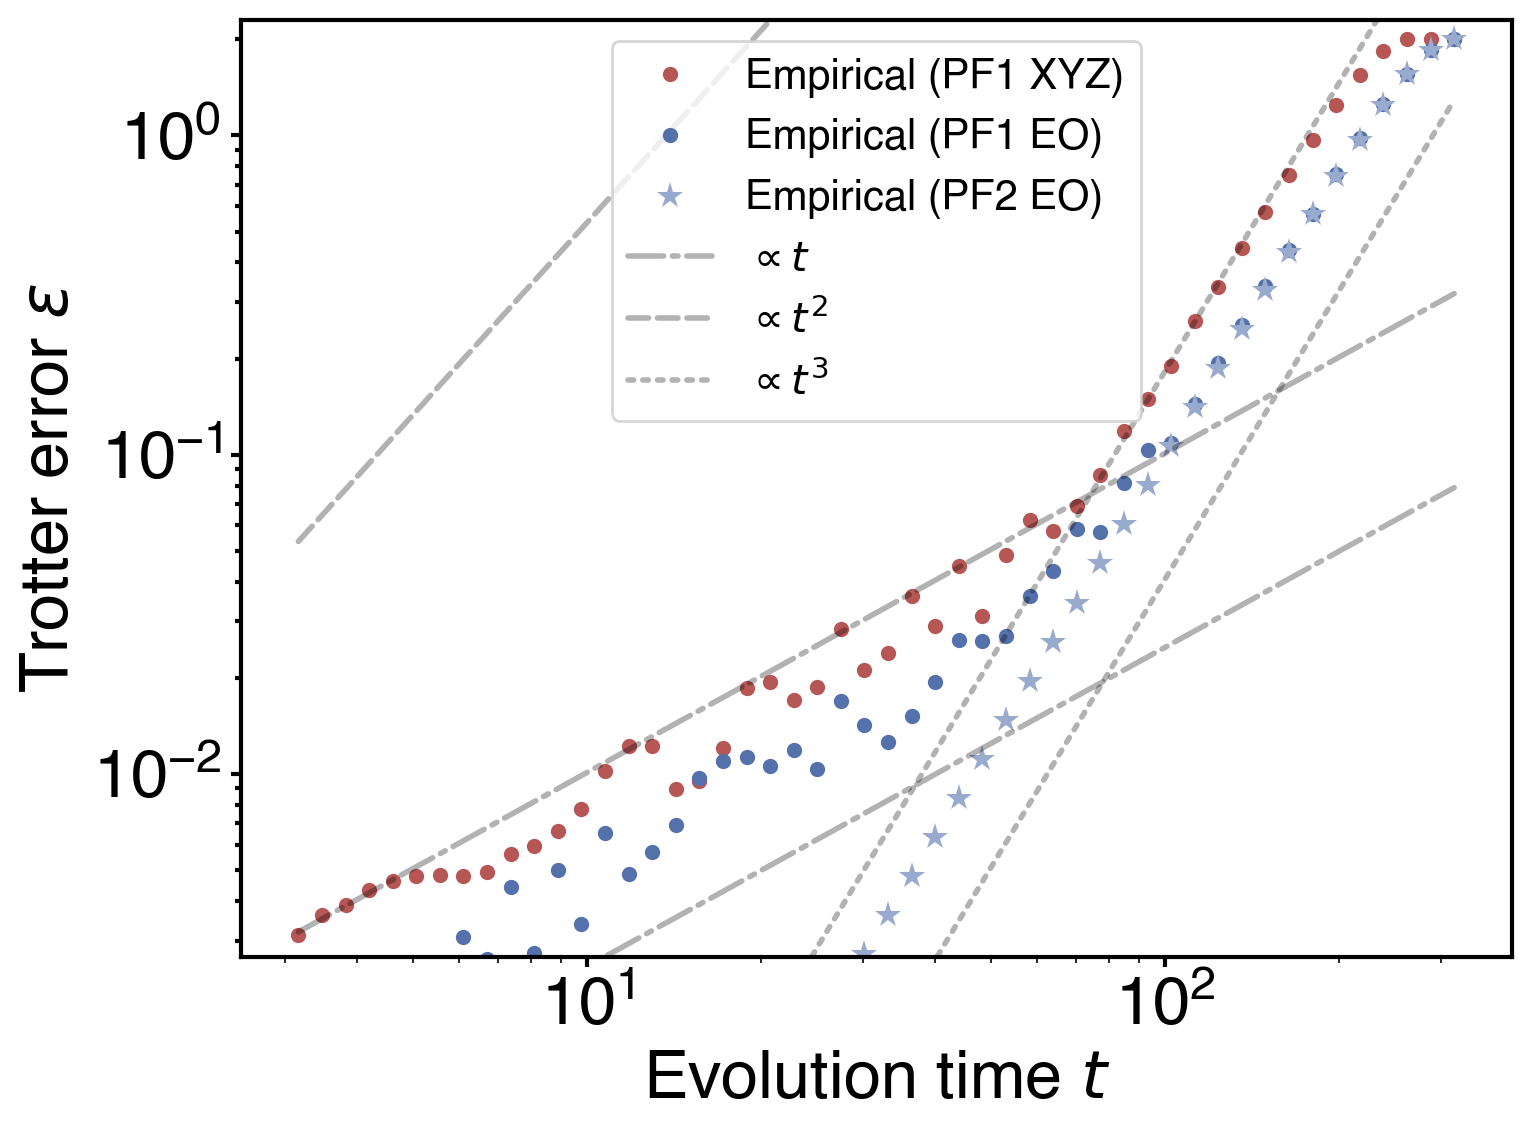

In [17]:
# plt.rc('font', size=MEDIUM_SIZE+0)  # controls default text sizes
cc, lcc = default_color_cycle, [lighten_color(color, 0.2) for color in default_color_cycle]
set_color_cycle(default_color_cycle, 0.2)
plt.rc('legend', fontsize=MEDIUM_SIZE-3) 
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

start1, end1 = int(2*len(t_list)/10), int(5*len(t_list)/10)
start2, end2 = int(7*len(t_list)/10), int(9*len(t_list)/10)
_, a_1, b_1 = linear_loglog_fit(t_list[start1:end1], data_t['emp_par1'][start1:end1], verbose=True)
_, a_2, b_2 = linear_loglog_fit(t_list[start2:end2], data_t['emp_xyz1'][start2:end2], verbose=True)
_, a_bnd, b_bnd = linear_loglog_fit(t_list, data_t['bnd_par1'], verbose=True)

# ax.plot(t_list, data_t['bnd_par1'], '*', label='Bound (EO)', markeredgewidth=0.0, c='#C87A8AFF')
# ax.plot(t_list, data_t['bnd_xyz1'], '*', label='Bound (XYZ)', markeredgewidth=0.0, c='#2A9EB5FF') "#8b9951FF"
ax.plot(t_list, data_t['emp_xyz1'], '.', label='Empirical (PF1 XYZ)', markeredgewidth=0.0)
ax.plot(t_list, data_t['emp_par1'], '.', label='Empirical (PF1 EO)', markeredgewidth=0.0)
ax.plot(t_list, data_t['emp_par2'], '*', label='Empirical (PF2 EO)', markeredgewidth=0.0, mfc=lcc[1], markersize=10)
ax.plot(t_list, [t*exp(b_1+1.2) for t in t_list], 'k-.', linewidth=2, alpha=0.3, label=fr'$\propto t$')
ax.plot(t_list, [t*exp(b_1-0.2) for t in t_list], 'k-.', linewidth=2, alpha=0.3)
ax.plot(t_list, [t**2*exp(b_bnd+1) for t in t_list], 'k--', linewidth=2, alpha=0.3, label=fr'$\propto t^2$')
# ax.plot(t_list, [t**2*exp(b_bnd-1) for t in t_list], 'k--', linewidth=2, alpha=0.3)
ax.plot(t_list, [t**3*exp(b_2-0.8) for t in t_list], 'k:', linewidth=2, alpha=0.3, label=fr'$\propto t^3$')
ax.plot(t_list, [t**3*exp(b_2-2.3) for t in t_list], 'k:', linewidth=2, alpha=0.3)
ax_set_text(ax, r'Evolution time $t$', r'Trotter error $\epsilon$', log='xy', ylim=[min(data_t['emp_xyz1']), max(data_t['emp_xyz1'])], legend='best')
title = f'PF1, TFI (J={J}, h={h}), r={r}'
print(f'title: <<{title}>>')
# ax.set_title(title) # ax.set_ylim([1e-4, 1e-0])
fig.savefig(f'{fig_dir}/{prefix}_errVSt_n={n}_r={r}_{suffix}.pdf')

### Error VS r

In [18]:
prefix, suffix = 'HNN', 'PF1'
n, t = 8, 20
J, h = 1, 0.2
r_list = sorted(list(set(np.logspace(2, 5, 30, dtype=int))))
# r_list = np.logspace(1, 1.5, 20, dtype=int)
print('r_list: ', r_list)
data_r = {key: [] for key in ['r', 'emp_xyz1', 'emp_eo1', 'bnd_xyz1', 'bnd_eo1', 'emp_xyz2', 'emp_eo2', 'bnd_xyz2', 'bnd_eo2', 'interf']}

for r in r_list:
    hnn = Nearest_Neighbour_1d(n=n, Jx=J, Jy=J, Jz=J, hx=h, hy=0, hz=0, pbc=True)
    # tfI = TF_Ising_1d(n, J, h)
    exact_U = expm(-1j * t * hnn.ham.to_matrix())
    appro_U_xyz1 = pf_r([h.to_matrix(True) for h in hnn.ham_xyz], t, r, order=1)
    appro_U_xyz2 = pf_r([h.to_matrix(True) for h in hnn.ham_xyz], t, r, order=2)
    appro_U_eo1 = pf_r([h.to_matrix(True) for h in hnn.ham_par], t, r, order=1)
    appro_U_eo2 = pf_r([h.to_matrix(True) for h in hnn.ham_par], t, r, order=2)
    data_r['emp_xyz1'].append(norm(exact_U - appro_U_xyz1, ord=2))
    data_r['emp_xyz2'].append(norm(exact_U - appro_U_xyz2, ord=2))
    data_r['emp_eo1'].append(norm(exact_U - appro_U_eo1, ord=2))
    data_r['emp_eo2'].append(norm(exact_U - appro_U_eo2, ord=2))
    data_r['bnd_xyz2'].append(tight_bound([term.to_matrix() for term in hnn.ham_xyz], 2, t, r))
    data_r['bnd_eo2'].append(tight_bound([term.to_matrix() for term in hnn.ham_par], 2, t, r))
    data_r['bnd_eo1'].append(tight_bound([term.to_matrix() for term in hnn.ham_par], 1, t, r))
    data_r['interf'].append(interference_bound([term.to_matrix() for term in hnn.ham_par], t, r))

r_list:  [100, 126, 161, 204, 259, 329, 417, 529, 672, 853, 1082, 1373, 1743, 2212, 2807, 3562, 4520, 5736, 7278, 9236, 11721, 14873, 18873, 23950, 30391, 38566, 48939, 62101, 78804, 100000]


NameError: name 'pf_r' is not defined

In [20]:
prefix, suffix = 'HNN', 'PF1'
n, t = 8, 20
J, h = 1, 0.2
r_list = sorted(list(set(np.logspace(2, 5, 30, dtype=int))))
# r_list = np.logspace(1, 1.5, 20, dtype=int)
print('r_list: ', r_list)
data_r = {key: [] for key in ['r', 'emp_xyz1', 'emp_eo1', 'bnd_xyz1', 'bnd_eo1', 'emp_xyz2', 'emp_eo2', 'bnd_xyz2', 'bnd_eo2', 'interf']}

hnn = Nearest_Neighbour_1d(n=n, Jx=J, Jy=J, Jz=J, hx=h, hy=0, hz=0, pbc=True)
# tfI = TF_Ising_1d(n, J, h)
exact_U = expm(-1j * t * hnn.ham.to_matrix())
for r in r_list:
    appro_U_xyz1 = pf(hnn.ham_xyz, t, r, order=1)
    appro_U_xyz2 = pf(hnn.ham_xyz, t, r, order=2)
    appro_U_eo1  = pf(hnn.ham_par, t, r, order=1)
    appro_U_eo2  = pf(hnn.ham_par, t, r, order=2)
    data_r['emp_xyz1'].append(norm(exact_U - appro_U_xyz1, ord=2))
    data_r['emp_xyz2'].append(norm(exact_U - appro_U_xyz2, ord=2))
    data_r['emp_eo1'].append(norm(exact_U - appro_U_eo1, ord=2))
    data_r['emp_eo2'].append(norm(exact_U - appro_U_eo2, ord=2))
    data_r['bnd_xyz2'].append(tight_bound([term.to_matrix() for term in hnn.ham_xyz], 2, t, r))
    data_r['bnd_eo2'].append(tight_bound([term.to_matrix() for term in hnn.ham_par], 2, t, r))
    data_r['bnd_eo1'].append(tight_bound([term.to_matrix() for term in hnn.ham_par], 1, t, r))
    data_r['interf'].append(interference_bound([term.to_matrix() for term in hnn.ham_par], t, r))

r_list:  [100, 126, 161, 204, 259, 329, 417, 529, 672, 853, 1082, 1373, 1743, 2212, 2807, 3562, 4520, 5736, 7278, 9236, 11721, 14873, 18873, 23950, 30391, 38566, 48939, 62101, 78804, 100000]


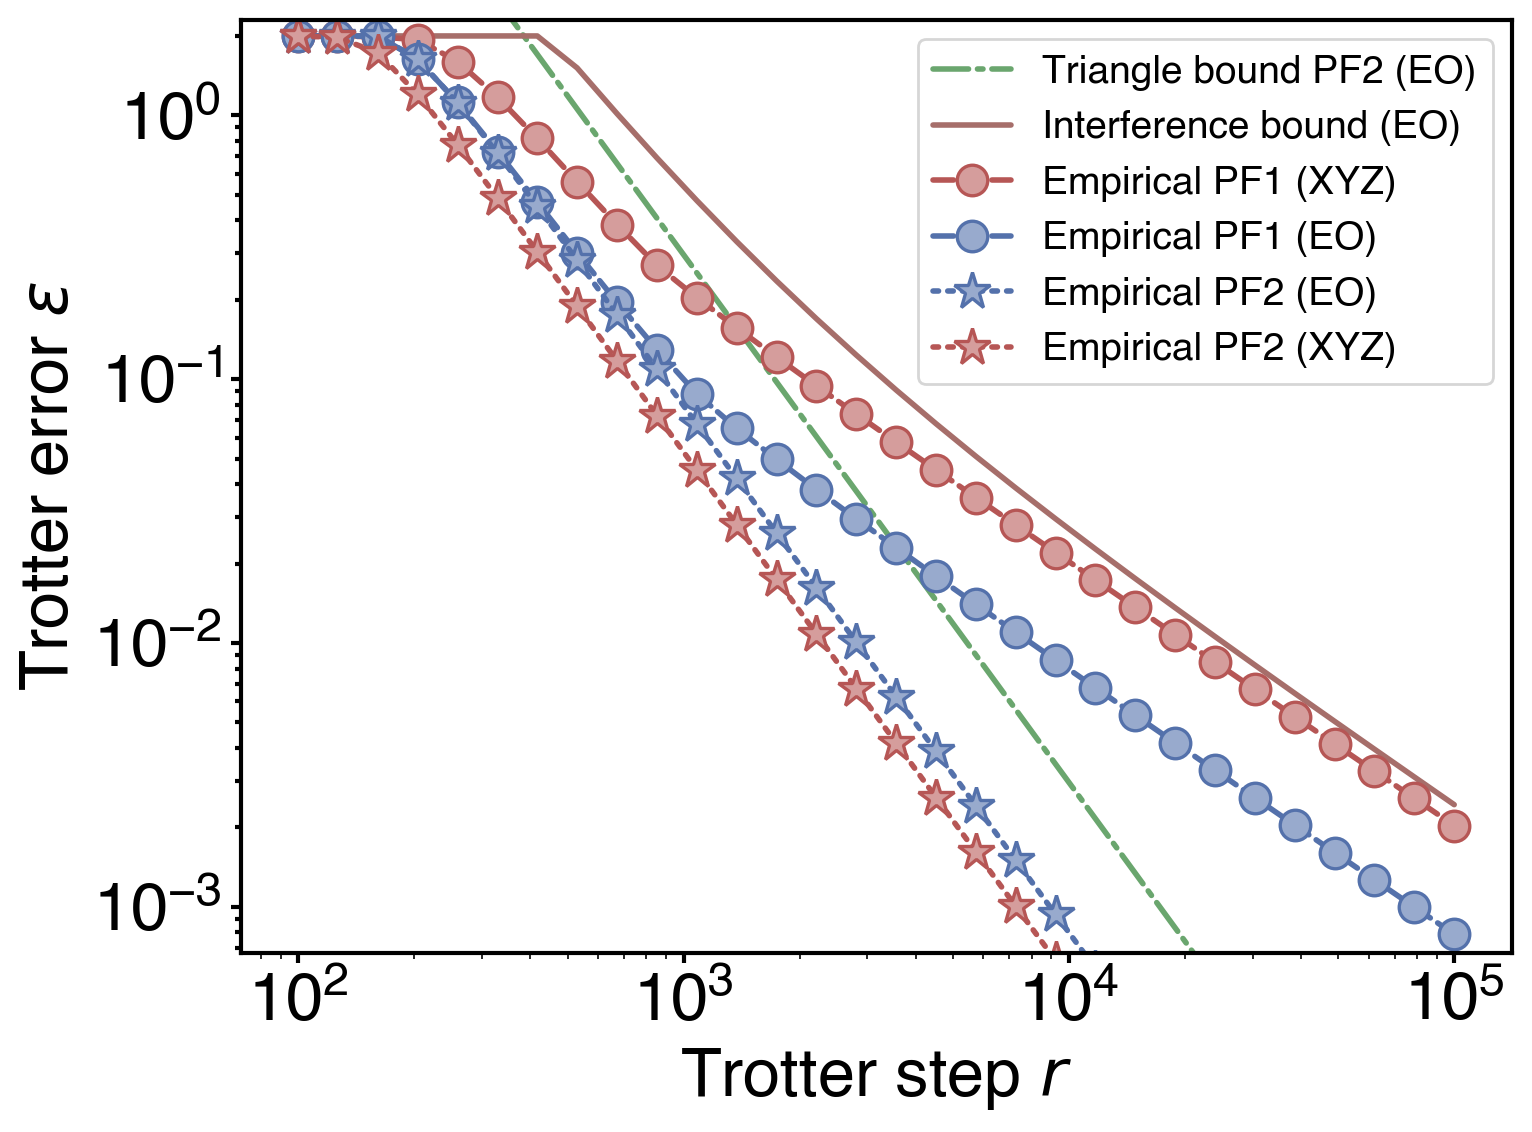

In [21]:
set_color_cycle(cc, 0.3)
mpl.rcParams['lines.markeredgewidth'] = 1.2
plt.rc('legend', fontsize=MEDIUM_SIZE-4)  
fig, ax = plt.subplots(1, 1)
# plot_fit(ax, r_list, data['bnd_eo2'], var='r', y_offset=1.45, x_offset=0.84, linewidth=0.01)
# ax.plot(r_list, data['bnd_eo1'], '-.', label='Triangle bound PF1 (EO)')
ax.plot(r_list, data_r['bnd_eo2'], '-.', label='Triangle bound PF2 (EO)', color=cc[2])
ax.plot(r_list, np.array(data_r['interf'])[:, 0], '-', label='Interference bound (EO)', color=cc[3])
# ax.plot(r_list, data_r['bnd_xz2'], '--', label='Triangle bound (XZ)')
# ax.plot(r_list, data_r['emp_eo1'], 'o-', label='Empirical PF1 (EO)')
ax.plot(r_list, data_r['emp_xyz1'], 'o--', label='Empirical PF1 (XYZ)', mfc=lcc[0], markeredgecolor=cc[0], color=cc[0])
ax.plot(r_list, data_r['emp_eo1'], 'o--', label='Empirical PF1 (EO)', mfc=lcc[1], markeredgecolor=cc[1], color=cc[1])
ax.plot(r_list, data_r['emp_eo2'], '*:', label='Empirical PF2 (EO)', mfc=lcc[1], markeredgecolor=cc[1], color=cc[1], markersize=14)
ax.plot(r_list, data_r['emp_xyz2'], '*:', label='Empirical PF2 (XYZ)', mfc=lcc[0], markeredgecolor=cc[0], color=cc[0], markersize=14)
ax_set_text(ax, r'Trotter step $r$', r'Trotter error $\epsilon$', log='xy', ylim=[min(data_r['emp_eo1']), max(data_r['emp_eo1'])])
fig.savefig(f'{fig_dir}/{prefix}_errVSr_n={n}_t={t}_{suffix}.pdf')

In [ ]:
bound = interf_bound[:, 0]
e1 = interf_bound[:, 1]
e2 = interf_bound[:, 2]
e3 = interf_bound[:, 3]
data_plot(t_list, bound, '-', linewidth=1.4, label=r'Interference bound (L=2)')
data_plot(t_list, e1, ':', alpha=0.7, label=r'Bound: $\min(||H_0||,||H_1||)\, t/r$', linewidth=1) # C_1
data_plot(t_list, e2, '--', alpha=0.7, label=r'Bound: $\frac{1}{2}||[H_0,H_1]||\, t^2/r$', linewidth=1) # C_2